In [ ]:
# !pip install -r requirements.txt
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=13f8afc990522b11e24a364cb998243131316d7e7b93ed2114faf825294be4fb
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 0. 라이브러리

# 1. Load Data

In [ ]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
import random

In [ ]:
# from tensorflow.python.client import device_lib
# tf.config.list_physical_devices('GPU')

In [ ]:

seed_num = 42
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data load
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)


# with open(f'{DATA_DIR}/Amazon_Grocery/amazon_grocery_attri.pickle', 'rb') as f:
#     attribute = pickle.load(f)

# txt
# \

In [ ]:
overall = train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]
print('train:validation:test = %.4f:%.4f:%.4f'%((train_set.shape[0] / overall), (valid_set.shape[0] / overall), (test_set.shape[0] / overall)))

train:validation:test = 0.7000:0.1000:0.2000


In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,senti_score,NeMFRating,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1633870,143756,31800,1.00,0.5719,3,3,4,0.00,0.00,0.00,0.00,16.67,0.00,0.00,33.33,0.00,16.67
3115182,272600,13746,1.00,0.0000,2,3,3,0.00,11.11,0.00,11.11,0.00,0.00,0.00,11.11,0.00,0.00
2383131,208589,23849,0.50,-0.2023,1,2,3,10.53,5.26,5.26,5.26,0.00,5.26,5.26,5.26,10.53,10.53
2079042,182422,14736,0.75,0.9666,3,3,5,5.04,4.20,9.24,8.40,6.72,7.56,5.04,4.20,14.29,13.45
651398,56973,53386,1.00,0.9260,3,3,5,0.00,27.27,0.00,4.55,18.18,0.00,13.64,40.91,0.00,27.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158490,13844,27705,1.00,0.7351,3,3,4,0.00,0.00,0.00,0.00,8.00,0.00,0.00,20.00,0.00,12.00
1734117,152410,28106,0.75,0.8750,3,3,5,0.00,3.77,0.00,3.77,3.77,0.00,3.77,11.32,3.77,5.66
1564450,137584,43164,1.00,0.6249,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.33
212205,18521,42215,1.00,0.4588,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
print(test_set.rating.isna().sum())
print(test_set.rating.isnull().sum())

0
0


# 3.Model

In [ ]:
def conv_block(n_layers, latent_dims, names):
    ModuleList = []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [ ]:
def ModelBuild(user_num, item_num, id_dims):

    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    # MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    # for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
    #     MLP_U_I = layer(MLP_U_I)

        #layer = 2

    # Sentiment
    # anger_input = Input(shape=(1,), dtype='int32', name='AngerInput')
    # anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    # fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    # joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    # sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    # surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    # trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')

    # Sentiment concatenation
    # Sentiment = Concatenate(name='SentimentLayer')([anger_input, anticipation_input, disgust_input, fear_input, joy_input, sadness_input, surprise_input, trust_input])
    # Sentiment = Dense(units=8, activation='relu', name='Dense_Sentiment')(Sentiment)

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([GMF])

    # for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1)))//2, 'GMF'):

    # MLP_U_I_S = layer(GMF)

    outputs = Dense(1, activation='sigmoid', name='outputs')(GMF)
    model = Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [ ]:
user_num = 281335
item_num = 59044

id_dims = [256,128, 64, 32, 16]# each 32 dims
total_layer_dims = 32 # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16

In [ ]:
model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims[0])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 UserInput (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 ItemInput (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 UserIDEmb (Embedding)          (None, 1, 256)       72021760    ['UserInput[0][0]']              
                                                                                                  
 ItemIDEmb (Embedding)          (None, 1, 256)       15115264    ['ItemInput[0][0]']              
                                                                                              

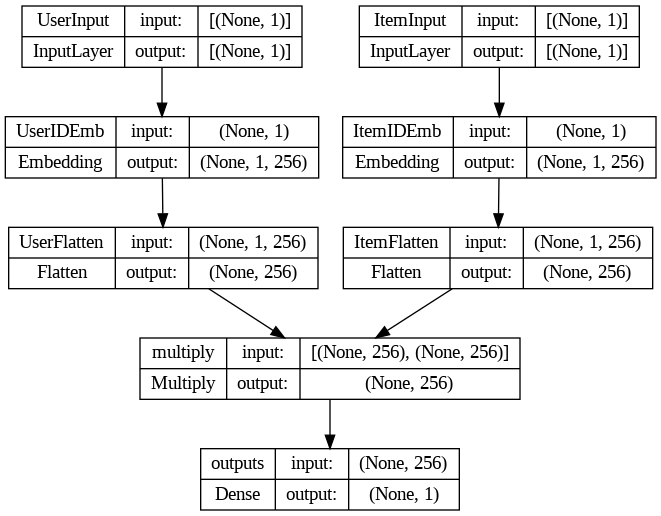

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

# 일단 파라미터 튜닝
- id_dim = [256, 128, 64, 32]
- lr = [0.0005, 0.0001, 0.005, 0.001]

In [ ]:
user_num = 281335
item_num = 59044

id_dims = [256, 128, 64, 32]
lr = [0.0005, 0.0001, 0.005, 0.001]

# id_dims = [32]
# lr = [0.0005]

In [ ]:
def model_run_param(id_dims,lr):

    tf.random.set_seed(seed_num)
    model = ModelBuild(user_num = 281335, item_num = 59044, id_dims = id_dims)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID']],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID']])
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    # layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    # MAE.append(MAE_temp)
    # RMSE.append(RMSE_temp)
    # param_embedding.append(embedding_size)
    # param_layer_dim.append(layer_dim)
    # param_lr.append(lr)

    return MAE_temp, RMSE_temp, embedding_size, lr

In [ ]:
MAE, RMSE, param_embedding, param_lr = [], [], [], []
for i in id_dims:
  for j in lr:
    MAE_temp, RMSE_temp, embedding_size, learning_rate = model_run_param(i,j)

    MAE.append(MAE_temp)
    RMSE.append(RMSE_temp)
    param_embedding.append(embedding_size)
    param_lr.append(learning_rate)

Epoch 1/100
2199/2199 [==============================] - 32s 14ms/step - loss: 0.5840 - val_loss: 0.5193
Epoch 2/100
2199/2199 [==============================] - 14s 7ms/step - loss: 0.4843 - val_loss: 0.4712
Epoch 3/100
2199/2199 [==============================] - 14s 7ms/step - loss: 0.3442 - val_loss: 0.4436
Epoch 4/100
2199/2199 [==============================] - 14s 7ms/step - loss: 0.2516 - val_loss: 0.4473
Epoch 5/100
2199/2199 [==============================] - 14s 6ms/step - loss: 0.2292 - val_loss: 0.4550
Epoch 6/100
2199/2199 [==============================] - 14s 6ms/step - loss: 0.2282 - val_loss: 0.4572
Epoch 6: early stopping
20099/20099 [==============================] - 24s 1ms/step
embedding:256,lr:0.0005
MAE: 0.781
RMSE: 1.059
Epoch 1/100
2199/2199 [==============================] - 27s 12ms/step - loss: 0.6624 - val_loss: 0.6342
Epoch 2/100
2199/2199 [==============================] - 14s 6ms/step - loss: 0.6100 - val_loss: 0.5884
Epoch 3/100
2199/2199 [============

In [ ]:
gmf_df = pd.DataFrame(zip(param_embedding, param_lr, MAE, RMSE), columns=['embedding size','Learning Rate','MAE','RMSE'])
gmf_df


,embedding size,Learning Rate,MAE,RMSE
0,256,0.0005,0.781234,1.058677
1,256,0.0001,0.790549,1.087264
2,256,0.0050,0.772791,1.053526
3,256,0.0010,0.756186,1.052681
4,128,0.0005,0.749530,1.065933
5,128,0.0001,0.805225,1.090159
6,128,0.0050,0.777108,1.057056
7,128,0.0010,0.754730,1.050478
8,64,0.0005,0.762192,1.065284
9,64,0.0001,0.814877,1.099398
